<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Исследовательский-анализ-данных" data-toc-modified-id="Исследовательский-анализ-данных-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Исследовательский анализ данных</a></span></li><li><span><a href="#Обучение-модели" data-toc-modified-id="Обучение-модели-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Обучение модели</a></span></li><li><span><a href="#Анализ-обученной-модели" data-toc-modified-id="Анализ-обученной-модели-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Анализ обученной модели</a></span></li></ul></div>

# Определение возраста покупателей

# Описание проекта

Сетевой супермаркет «Хлеб-Соль» внедряет систему компьютерного зрения для обработки фотографий покупателей. Фотофиксация в прикассовой зоне поможет определять возраст клиентов, чтобы:

* Анализировать покупки и предлагать товары, которые могут заинтересовать покупателей этой возрастной группы;
* Контролировать добросовестность кассиров при продаже алкоголя.

# План работы

* Провести исследовательский анализ набора фотографий.
* Подготовить данные к обучению.
* Обучить нейронную сеть и рассчитайте её качество.

## Исследовательский анализ данных

In [7]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import seaborn as sns

In [8]:
labels = pd.read_csv('/datasets/faces/labels.csv')
train_datagen = ImageDataGenerator(rescale=1./255)
train_gen_flow = train_datagen.flow_from_dataframe(
        dataframe=labels,
        directory='/datasets/faces/final_files/',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=32,
        class_mode='raw',
        seed=12345)

Found 7591 validated image filenames.


In [9]:
labels.shape

(7591, 2)

Выборка не большая, работаем с тем, что имеется. Посмотрим на распределение покупателей по возрастам.

array([[<AxesSubplot:title={'center':'real_age'}>]], dtype=object)

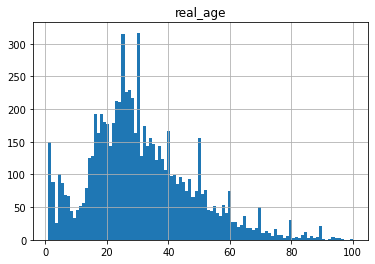

In [10]:
labels.hist(bins=100)

In [13]:
labels.describe()

,real_age
count,7591.000000
mean,31.201159
std,17.145060
min,1.000000
25%,20.000000
50%,29.000000
75%,41.000000
max,100.000000


Проверим данные на наличие выбросов.

<AxesSubplot:xlabel='real_age'>

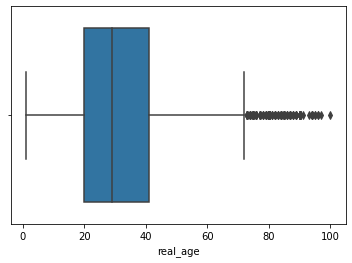

In [11]:
sns.boxplot(x=labels['real_age']) 

Основной диапазон значений возраста находится в границах 20-40 лет. Имеются выбросы после 75 лет. Но если посмотреть на гистограмма, то можно заметить, что таких возрастных покупателей не много. Есть примерно 40 человек в возрасте 80 лет и 30 человек в возрасте 90 лет. Я не считаю, что это на самом деле выбросы. Это просто долгожители и их не много. Удалять выбросы не буду.

Посмотри на имеющиеся изображения.

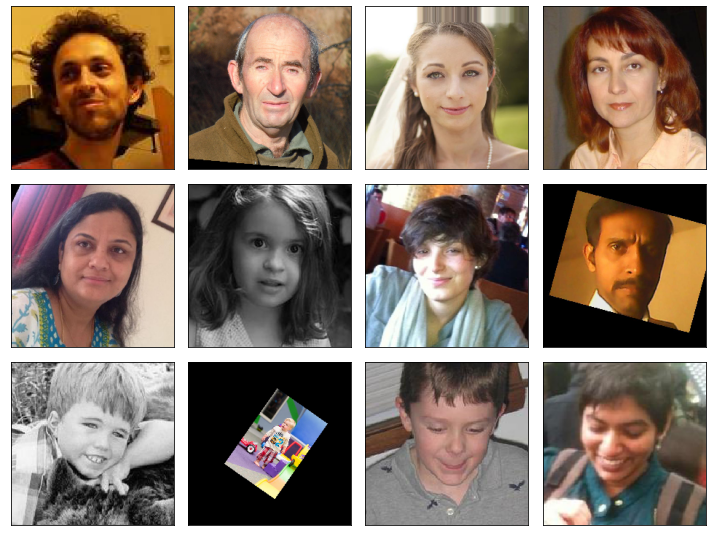

In [10]:
features, target = next(train_gen_flow)

fig = plt.figure(figsize=(10,10))
for i in range(12):
    fig.add_subplot(4, 4, i+1)
    plt.imshow(features[i])
    plt.xticks([])
    plt.yticks([])
    plt.tight_layout()

**Вывод**
* в нашем рапоряжении 7591 изображение
* средний возраст находится в интервале 18-40 лет
* просмотрев несколько графиков можно сделать вывод, что модели будет тяжело обучиться:
 * есть размытые фото
 * есть фото где имеется помеха перед лицом(очки, руки, головные уборы)
 * много детских фото
 * есть удаленные ракурсы
 * имеются черно-белые фотографии
 * общая ориентация фотографий - вертикальная
 * имеется ряд фотографий с горизонтальыми сдвигами 
 * фотографии разных размеров
 * т.к. выборка небольшая, то для обучения модели применим отражение по горизонтали

## Обучение модели

Перенесите сюда код обучения модели и её результат вывода на экран.


(Код в этом разделе запускается в отдельном GPU-тренажёре, поэтому оформлен не как ячейка с кодом, а как код в текстовой ячейке)

```python

from tensorflow.keras.applications.resnet import ResNet50
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
import numpy as np
import pandas as pd


def load_train(path):
    data = pd.read_csv(path + 'labels.csv')
    datagen = ImageDataGenerator(validation_split=0.25, horizontal_flip=True, rescale=1./255)
    train_datagen_flow = datagen.flow_from_dataframe(
        dataframe=data,
        directory=path + 'final_files/',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=16,
        class_mode='raw',
        subset='training',
        seed=12345)

    return train_datagen_flow

def load_test(path):
    data = pd.read_csv(path + 'labels.csv')
    datagen = ImageDataGenerator(validation_split=0.25, rescale=1./255)
    test_datagen_flow = datagen.flow_from_dataframe(
        dataframe=data,
        directory=path + 'final_files/',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=16,
        class_mode='raw',
        subset='validation',
        seed=12345)

    return test_datagen_flow


def create_model(input_shape):

    backbone = ResNet50(input_shape=input_shape,
                    weights='imagenet', 
                    include_top=False)
    model = Sequential()
    model.add(backbone)
    model.add(GlobalAveragePooling2D())
    model.add(Dense(1, activation='relu'))

    optimizer = Adam(lr=0.0001)
    model.compile(optimizer=optimizer, loss='mean_squared_error',
                  metrics=['mae'])


    return model


def train_model(model, train_data, test_data, batch_size=None, epochs=10,
                steps_per_epoch=None, validation_steps=None):

    if steps_per_epoch is None:
        steps_per_epoch = len(train_data)
    if validation_steps is None:
        validation_steps = len(test_data)

    model.fit(train_data,
              validation_data=test_data,
              batch_size=batch_size, 
              epochs=epochs,
              steps_per_epoch=steps_per_epoch,
              validation_steps=validation_steps,
              verbose=2)

    return model

```

```

Train for 356 steps, validate for 119 steps
Epoch 1/10
2022-07-29 21:51:58.413672: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcublas.so.10
2022-07-29 21:51:58.719836: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudnn.so.7
356/356 - 50s - loss: 219.7494 - mae: 10.7754 - val_loss: 330.5916 - val_mae: 13.4506
Epoch 2/10
356/356 - 40s - loss: 84.4685 - mae: 6.9656 - val_loss: 155.0275 - val_mae: 9.1946
Epoch 3/10
356/356 - 40s - loss: 60.5256 - mae: 5.9228 - val_loss: 75.1682 - val_mae: 6.5130
Epoch 4/10
356/356 - 40s - loss: 43.1615 - mae: 4.9905 - val_loss: 70.3818 - val_mae: 6.2333
Epoch 5/10
356/356 - 40s - loss: 33.0268 - mae: 4.3916 - val_loss: 76.5757 - val_mae: 6.4521
Epoch 6/10
356/356 - 40s - loss: 25.0694 - mae: 3.8247 - val_loss: 73.0679 - val_mae: 6.3016
Epoch 7/10
356/356 - 40s - loss: 18.7009 - mae: 3.3116 - val_loss: 82.0155 - val_mae: 6.6853
Epoch 8/10
356/356 - 40s - loss: 15.9150 - mae: 3.0249 - val_loss: 68.6772 - val_mae: 6.0827
Epoch 9/10
356/356 - 40s - loss: 14.6314 - mae: 2.9010 - val_loss: 72.9755 - val_mae: 6.3309
Epoch 10/10
356/356 - 40s - loss: 13.5592 - mae: 2.7972 - val_loss: 65.1850 - val_mae: 5.9298
WARNING:tensorflow:sample_weight modes were coerced from
  ...
    to  
  ['...']
119/119 - 10s - loss: 65.1850 - mae: 5.9298
Test MAE: 5.9298

```

**Вывод**
* удалось достичь значения MAE = 5.9298, за счет параметра weights='imagenet'

## Анализ обученной модели

Обученная модель позволяет с высокой точностью предсказывать возраст покупателей. 
Удалось достичь значение MAE на тестовой выборке = 5.9298. Т.е. модель ошибается в определении точного возраста покупателя всего на 6 лет. Т.к. категория покупателей в супермаркете «Хлеб-Соль» скорее всего будет разделена по возрастным группам в районе 10-15 лет, ошибка в определении возраста на 6 лет не будет влият на итоговый подсчёт покупателей по возрастным группам.